# Рекомендация тарифов

Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. 
**Задача:** построить модель для задачи классификации, которая выберет подходящий тариф. 

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
   calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0


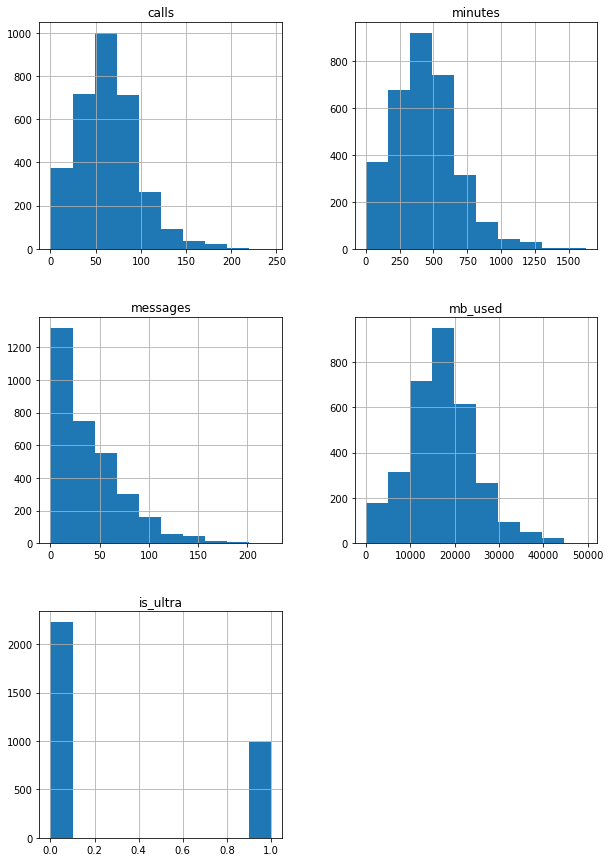

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.info()
print(df.head())
df.hist(figsize=(10, 15))
plt.show()

Согласно описанию проекта, предобработка данных не требуется, однако на мой взгляд стоит сделать следующее:
- Изменить тип данных столбцов, соответствующих числу звонков и сообщений на int 
- Изменить тип данных столбца, соответствующего тарифу на bool
- Проверить датафрейм на наличие пропусков и дубликатов (на всякий случай)

In [3]:
df['calls']=df['calls'].astype('int')
df['messages']=df['messages'].astype('int')
df['is_ultra']=df['is_ultra'].astype('bool')

print(df.duplicated().sum())
print(df.isna().sum())

df.info()

0
calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   bool   
dtypes: bool(1), float64(2), int64(2)
memory usage: 103.7 KB


*Пропусков и дубликатов не оказалось.*

## Разбиение данных на выборки

Целевой признак - информация о том, каким тарифом пользовался клиент.

In [4]:
df_ohe = pd.get_dummies(df, drop_first=True)

features = df_ohe.drop(['is_ultra'], axis = 1)
target = df_ohe['is_ultra']

Разделим датафрейм на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [5]:
features, features_test, target, target_test = train_test_split(
    features, target, test_size=.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.25, random_state=12345)

## Исследовение моделей

 ### Случайный лес

In [6]:
forest_best_model = None
best_accuracy = 0
best_est = 0
best_depth = 0
best_feature = 0

for feature in range (1, 5):
    for depth in range (1, 15): 
        for est in range (1, 15):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, max_features=feature) 
            model.fit(features_train, target_train) 
            accuracy = model.score(features_valid, target_valid) 
            if accuracy > best_accuracy:
                forest_best_model = model
                best_accuracy = accuracy
                best_est = est
                best_depth = depth
                best_feature = feature 
        
print("Accuracy наилучшей модели на валидационной выборке:", best_accuracy)
print('Параметры наилучшей модели')
print('n_estimators -', best_est)
print('max_depth -', best_depth)
print('max_features -', best_feature)

Accuracy наилучшей модели на валидационной выборке: 0.8055987558320373
Параметры наилучшей модели
n_estimators - 8
max_depth - 13
max_features - 1


В модели "Случаный лес" рассмотрены влияния гиперпараметров n_estimators, max_depth и max_features. Значения для первых двух гиперпараметров выбиралось из диапозона (1, 15), значения для max_features выбираолсь из диапозона (1, 5).

Наилучший результат для модели "Случайный лес":
- n_estimators - 8
- max_depth - 13
- max_features - 1

**Accuracy = 0.806**

### Логистическая регрессия

In [7]:
logistic_best_model = LogisticRegression(random_state=12345, solver='lbfgs')
best_accuracy = 0
best_iter = 0

for iters in range(100, 2000, 100):
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iters)
    model.fit(features_train, target_train) 
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy:
        logistic_best_model = model
        best_accuracy = accuracy
        best_iter = iters
        
print("Accuracy наилучшей модели на валидационной выборке:", best_accuracy)
print('Параметры наилучшей модели')
print('max_iter -', best_iter)  


Accuracy наилучшей модели на валидационной выборке: 0.7262830482115086
Параметры наилучшей модели
max_iter - 100


В модели "Логистическая регрессия" рассмотрено влияние гиперпараметра max_iter. Значения выбиралось из диапозона (100, 2000) с шагом 100.

Наилучший результат для модели "Логистическая регрессия":
- max_iter - 100

**Accuracy = 0.726**

Наилучший результат у модели "Случайный лес" с параметрами:
- n_estimators - 8
- max_depth - 13
- max_features - 1

Со значением accuracy = 0.806

## Проверка модели на тестовой выборке

### Проверка модели Случайный лес

In [8]:
forest_predict = forest_best_model.predict(features_test)
print('Тестовое значение accuracy для модели "Случайный лес" с наилучшими параметрами:', accuracy_score(target_test, forest_predict))



Тестовое значение accuracy для модели "Случайный лес" с наилучшими параметрами: 0.7791601866251944


### Проверка модели логистическая регрессия

In [9]:
logistic_predict = logistic_best_model.predict(features_test)
print('Тестовое значение accuracy для модели "Логистическая регрессия" с наилучшими параметрами:', accuracy_score(target_test, logistic_predict))

Тестовое значение accuracy для модели "Логистическая регрессия" с наилучшими параметрами: 0.7589424572317263


## Проверка модели на адекватность

Проверка модели на адекватность подразумевает сравнение ее со случайной моделью. Точность(значение accuracy) для такой модели = 0.5.
Обе модели показали значение accuracy больше 0.5 (и даже больше 0.7) как на валидационной, так и на тестовой выборках, что свидетельствует об адекватности модели.

## Вывод
Для модели "Случайный лес" с параметрами:
- n_estimators - 8
- max_depth - 13
- max_features - 1

Были получены следующие значения accuracy:
- На валидационной выборке: 0.806
- На тестовой выборке: 0.779

Для модели "Логистическая регрессия" с параметром:
- max_iter - 100

Были получены следующие значения accuracy:
- На валидационной выборке: 0.726
- На тестовой выборке: 0.759

Значения точности всех моделей >0.5, что говорит об их адекватности.

По итогам обоих значений accuracy, модель "Случайный лес", с приведенными выше параметрами, оказалась точней модели "Логистическая регрессия".